# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [102]:
import gym
import numpy as np

In [103]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [104]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [105]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [106]:
batch[0], batch[0][1].shape

([1,
  array([ 0.00991876,  0.22455611,  0.01431924, -0.29821834]),
  1.0,
  False,
  {}],
 (4,))

In [107]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [108]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.7794641392047863 -2.297466170075933


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [109]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, rewards, targetQs

In [110]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [111]:
# Discriminator/Dopamine: Reward/Q netowrk
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fuse/merge the input states and action (sensorymotory input)
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer: logits/Qvalue & predictions/reward
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.sigmoid(logits)

        # return actions logits
        return logits

In [112]:
def model_loss(actions, states, rewards, # Calculating Qs
               targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    # # Calculate targetQs/nextQs
    # actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})            
    # rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
                
    # Calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    rewarded_actions_logits = tf.multiply(actions_logits, tf.reshape(rewards, shape=[-1, 1]))
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_Qs_onehot = tf.multiply(rewarded_actions_logits[:-1], actions_onehot[1:])
    g_Qs = tf.reduce_max(g_Qs_onehot, axis=1)
    
    # Training the discriminator: to learn the reward/Q/value function
    rewarded_actions_preds = tf.nn.softmax(rewarded_actions_logits)
    d_Qs = discriminator(actions=rewarded_actions_preds, states=states, hidden_size=hidden_size)
    
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(g_Qs - targetQs[1:]))
    d_loss = tf.reduce_mean(tf.square(d_Qs[:-1] - targetQs[1:]))
    # d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_Qs, 
    #                                                                 labels=tf.reshape(rewards, shape=[-1, 1])))
    
    return actions_logits, g_loss, d_loss

In [113]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [114]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            rewards=self.rewards, states=self.states, actions=self.actions, # Calculating Qs 
            targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [115]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [116]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [117]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 50                # number of samples in the memory/ experience as mini-batch size

In [118]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [119]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [120]:
state, reward, action

(array([ 0.10567384,  0.55273066, -0.19435143, -1.07959994]), 1.0, 1)

In [121]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
g_loss_list = [] # loss
d_loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        g_loss_batch = []
        d_loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            last_action_logits = rewarded_actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})            
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.rewards: rewards, 
                         model.targetQs: Qs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)

            # For average loss in one episode/epoch
            g_loss_batch.append(g_loss)
            d_loss_batch.append(d_loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average g_loss: {:.9f}'.format(np.mean(g_loss_batch)),
              'Average d_loss: {:.9f}'.format(np.mean(d_loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        g_loss_list.append((ep, np.mean(g_loss_batch)))
        d_loss_list.append((ep, np.mean(d_loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 13.0 Average g_loss: 0.015965002 Average d_loss: 0.029237164 Explore P: 0.998614970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 43.0 Average g_loss: 0.028939592 Average d_loss: 0.053518083 Explore P: 0.994274620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9.0 Average g_loss: 0.024792161 Average d_loss: 0.029760495 Explore P: 0.993290837
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 13.0 Average g_loss: 0.034346707 Average d_loss: 0.006966678 Explore P: 0.991915193
-----

-------------------------------------------------------------------------------
Episode: 31 Total reward: 49.0 Average g_loss: 0.032108709 Average d_loss: 0.002414257 Explore P: 0.920601111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 14.0 Average g_loss: 0.039301824 Average d_loss: 0.002439590 Explore P: 0.919236233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 21.0 Average g_loss: 0.039319381 Average d_loss: 0.003234509 Explore P: 0.917238112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 19.0 Average g_loss: 0.038320035 Average d_loss: 0.003913675 Explore P: 0.915425449


-------------------------------------------------------------------------------
Episode: 62 Total reward: 28.0 Average g_loss: 0.033842899 Average d_loss: 0.003393229 Explore P: 0.862015691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 47.0 Average g_loss: 0.027442425 Average d_loss: 0.001836002 Explore P: 0.857935815
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 13.0 Average g_loss: 0.024914537 Average d_loss: 0.001380301 Explore P: 0.856749535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 65 Total reward: 16.0 Average g_loss: 0.029678548 Average d_loss: 0.002652264 Explore P: 0.855311284


-------------------------------------------------------------------------------
Episode: 93 Total reward: 34.0 Average g_loss: 0.031680815 Average d_loss: 0.002563793 Explore P: 0.810074576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 13.0 Average g_loss: 0.034381460 Average d_loss: 0.002325515 Explore P: 0.808955255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 12.0 Average g_loss: 0.036835570 Average d_loss: 0.002715820 Explore P: 0.807917288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 96 Total reward: 13.0 Average g_loss: 0.042138305 Average d_loss: 0.004558457 Explore P: 0.806800986


-------------------------------------------------------------------------------
Episode: 124 Total reward: 23.0 Average g_loss: 0.033428952 Average d_loss: 0.003164452 Explore P: 0.762202029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 125 Total reward: 15.0 Average g_loss: 0.029706785 Average d_loss: 0.002910163 Explore P: 0.760999468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 126 Total reward: 11.0 Average g_loss: 0.029904984 Average d_loss: 0.002853855 Explore P: 0.760098809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 29.0 Average g_loss: 0.030654721 Average d_loss: 0.002868992 Explore P: 0.757851

-------------------------------------------------------------------------------
Episode: 155 Total reward: 16.0 Average g_loss: 0.032717537 Average d_loss: 0.002686664 Explore P: 0.712822902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 156 Total reward: 7.0 Average g_loss: 0.036553696 Average d_loss: 0.004071687 Explore P: 0.712260869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 157 Total reward: 15.0 Average g_loss: 0.036391795 Average d_loss: 0.004388471 Explore P: 0.711138150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 158 Total reward: 11.0 Average g_loss: 0.038951874 Average d_loss: 0.004588787 Explore P: 0.7102972

-------------------------------------------------------------------------------
Episode: 187 Total reward: 16.0 Average g_loss: 0.036973793 Average d_loss: 0.003219421 Explore P: 0.675011905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 188 Total reward: 10.0 Average g_loss: 0.034974787 Average d_loss: 0.003415776 Explore P: 0.674280794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 189 Total reward: 13.0 Average g_loss: 0.033130094 Average d_loss: 0.003828751 Explore P: 0.673351452
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 190 Total reward: 11.0 Average g_loss: 0.032229494 Average d_loss: 0.003631225 Explore P: 0.672555

-------------------------------------------------------------------------------
Episode: 218 Total reward: 16.0 Average g_loss: 0.036474187 Average d_loss: 0.003779231 Explore P: 0.640494822
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 219 Total reward: 16.0 Average g_loss: 0.038531996 Average d_loss: 0.004226382 Explore P: 0.639423892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 220 Total reward: 9.0 Average g_loss: 0.041491378 Average d_loss: 0.004834091 Explore P: 0.638794782
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 221 Total reward: 8.0 Average g_loss: 0.043855622 Average d_loss: 0.006084444 Explore P: 0.63822912

-------------------------------------------------------------------------------
Episode: 250 Total reward: 30.0 Average g_loss: 0.035516348 Average d_loss: 0.003325232 Explore P: 0.601880611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 251 Total reward: 14.0 Average g_loss: 0.045499325 Average d_loss: 0.004684498 Explore P: 0.600993455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 252 Total reward: 33.0 Average g_loss: 0.051130205 Average d_loss: 0.004582752 Explore P: 0.598987489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 253 Total reward: 14.0 Average g_loss: 0.050458144 Average d_loss: 0.004887145 Explore P: 0.598104

-------------------------------------------------------------------------------
Episode: 281 Total reward: 14.0 Average g_loss: 0.035301283 Average d_loss: 0.003819427 Explore P: 0.571383876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 12.0 Average g_loss: 0.035492025 Average d_loss: 0.003886990 Explore P: 0.570654551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 29.0 Average g_loss: 0.033382382 Average d_loss: 0.003279750 Explore P: 0.568975108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 284 Total reward: 11.0 Average g_loss: 0.033461444 Average d_loss: 0.002872041 Explore P: 0.568304

-------------------------------------------------------------------------------
Episode: 312 Total reward: 22.0 Average g_loss: 0.028866841 Average d_loss: 0.003080374 Explore P: 0.541819924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 18.0 Average g_loss: 0.029744575 Average d_loss: 0.002829005 Explore P: 0.540810425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 11.0 Average g_loss: 0.032255869 Average d_loss: 0.003464198 Explore P: 0.540173835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 13.0 Average g_loss: 0.035762791 Average d_loss: 0.004125605 Explore P: 0.539432

-------------------------------------------------------------------------------
Episode: 343 Total reward: 14.0 Average g_loss: 0.034999713 Average d_loss: 0.003870065 Explore P: 0.514266523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 16.0 Average g_loss: 0.034669168 Average d_loss: 0.004063115 Explore P: 0.513409998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 15.0 Average g_loss: 0.034407087 Average d_loss: 0.004297652 Explore P: 0.512605186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 19.0 Average g_loss: 0.033503331 Average d_loss: 0.004018321 Explore P: 0.511600

-------------------------------------------------------------------------------
Episode: 374 Total reward: 13.0 Average g_loss: 0.035939489 Average d_loss: 0.004341065 Explore P: 0.488619033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 375 Total reward: 10.0 Average g_loss: 0.037206899 Average d_loss: 0.004547956 Explore P: 0.488092842
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 376 Total reward: 15.0 Average g_loss: 0.035837270 Average d_loss: 0.004311913 Explore P: 0.487328505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 377 Total reward: 11.0 Average g_loss: 0.038555335 Average d_loss: 0.004592680 Explore P: 0.486756

-------------------------------------------------------------------------------
Episode: 406 Total reward: 23.0 Average g_loss: 0.033775177 Average d_loss: 0.003516487 Explore P: 0.462869925
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 407 Total reward: 14.0 Average g_loss: 0.034173977 Average d_loss: 0.003719637 Explore P: 0.462191129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 12.0 Average g_loss: 0.036178466 Average d_loss: 0.003602699 Explore P: 0.461603663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 16.0 Average g_loss: 0.037887622 Average d_loss: 0.003908149 Explore P: 0.460836

-------------------------------------------------------------------------------
Episode: 438 Total reward: 13.0 Average g_loss: 0.036074635 Average d_loss: 0.003862354 Explore P: 0.437949391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 13.0 Average g_loss: 0.035881419 Average d_loss: 0.004107852 Explore P: 0.437350681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 17.0 Average g_loss: 0.037497327 Average d_loss: 0.004864158 Explore P: 0.436582142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 18.0 Average g_loss: 0.037249159 Average d_loss: 0.004413487 Explore P: 0.435772

-------------------------------------------------------------------------------
Episode: 469 Total reward: 10.0 Average g_loss: 0.037746727 Average d_loss: 0.004973276 Explore P: 0.418423629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 12.0 Average g_loss: 0.037987452 Average d_loss: 0.004864322 Explore P: 0.417893024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 471 Total reward: 17.0 Average g_loss: 0.037187345 Average d_loss: 0.004492200 Explore P: 0.417159477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 472 Total reward: 19.0 Average g_loss: 0.034260262 Average d_loss: 0.003632780 Explore P: 0.416345

-------------------------------------------------------------------------------
Episode: 500 Total reward: 18.0 Average g_loss: 0.037956763 Average d_loss: 0.003576538 Explore P: 0.397728341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 13.0 Average g_loss: 0.036971014 Average d_loss: 0.003719164 Explore P: 0.397185901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 9.0 Average g_loss: 0.038671695 Average d_loss: 0.004251635 Explore P: 0.396798909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 12.0 Average g_loss: 0.034895334 Average d_loss: 0.003987715 Explore P: 0.3962963

-------------------------------------------------------------------------------
Episode: 531 Total reward: 13.0 Average g_loss: 0.043839581 Average d_loss: 0.005992474 Explore P: 0.380074724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 16.0 Average g_loss: 0.038814396 Average d_loss: 0.004907943 Explore P: 0.379446132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 8.0 Average g_loss: 0.037964299 Average d_loss: 0.004591147 Explore P: 0.379113780
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 10.0 Average g_loss: 0.038531646 Average d_loss: 0.004587996 Explore P: 0.3787079

-------------------------------------------------------------------------------
Episode: 562 Total reward: 12.0 Average g_loss: 0.041279037 Average d_loss: 0.004816863 Explore P: 0.364002843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 12.0 Average g_loss: 0.041768357 Average d_loss: 0.004857011 Explore P: 0.363542938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 13.0 Average g_loss: 0.040389504 Average d_loss: 0.004918391 Explore P: 0.363048324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 13.0 Average g_loss: 0.039904006 Average d_loss: 0.004386070 Explore P: 0.362554

-------------------------------------------------------------------------------
Episode: 594 Total reward: 10.0 Average g_loss: 0.037266877 Average d_loss: 0.004271545 Explore P: 0.347142248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 11.0 Average g_loss: 0.037923042 Average d_loss: 0.004545518 Explore P: 0.346737920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 596 Total reward: 10.0 Average g_loss: 0.037914235 Average d_loss: 0.004556514 Explore P: 0.346367712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 597 Total reward: 22.0 Average g_loss: 0.038191773 Average d_loss: 0.004309304 Explore P: 0.345594

-------------------------------------------------------------------------------
Episode: 626 Total reward: 10.0 Average g_loss: 0.039388023 Average d_loss: 0.004177816 Explore P: 0.330827932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 13.0 Average g_loss: 0.038867317 Average d_loss: 0.004243976 Explore P: 0.330379088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 12.0 Average g_loss: 0.037569288 Average d_loss: 0.004532493 Explore P: 0.329962865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 629 Total reward: 15.0 Average g_loss: 0.038334809 Average d_loss: 0.004523406 Explore P: 0.329451

-------------------------------------------------------------------------------
Episode: 658 Total reward: 22.0 Average g_loss: 0.038803868 Average d_loss: 0.004660988 Explore P: 0.315425212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 11.0 Average g_loss: 0.040378030 Average d_loss: 0.004392162 Explore P: 0.315058921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 14.0 Average g_loss: 0.039648995 Average d_loss: 0.004040598 Explore P: 0.314601676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 12.0 Average g_loss: 0.040020924 Average d_loss: 0.004173618 Explore P: 0.314205

-------------------------------------------------------------------------------
Episode: 690 Total reward: 16.0 Average g_loss: 0.035564475 Average d_loss: 0.004012112 Explore P: 0.301752238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 691 Total reward: 14.0 Average g_loss: 0.035552386 Average d_loss: 0.003870851 Explore P: 0.301314938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 15.0 Average g_loss: 0.035027519 Average d_loss: 0.003798748 Explore P: 0.300849207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 13.0 Average g_loss: 0.035651553 Average d_loss: 0.003792405 Explore P: 0.300442

-------------------------------------------------------------------------------
Episode: 722 Total reward: 13.0 Average g_loss: 0.040121045 Average d_loss: 0.004396653 Explore P: 0.288942298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 723 Total reward: 14.0 Average g_loss: 0.040007111 Average d_loss: 0.004506688 Explore P: 0.288524198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 17.0 Average g_loss: 0.039182819 Average d_loss: 0.004451214 Explore P: 0.288023306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 12.0 Average g_loss: 0.039880529 Average d_loss: 0.004315466 Explore P: 0.287662

-------------------------------------------------------------------------------
Episode: 753 Total reward: 20.0 Average g_loss: 0.035362903 Average d_loss: 0.003658606 Explore P: 0.276401600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 17.0 Average g_loss: 0.038044479 Average d_loss: 0.003680258 Explore P: 0.275922508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 14.0 Average g_loss: 0.040761869 Average d_loss: 0.003814520 Explore P: 0.275523923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 756 Total reward: 13.0 Average g_loss: 0.042266525 Average d_loss: 0.004338750 Explore P: 0.275152

-------------------------------------------------------------------------------
Episode: 785 Total reward: 14.0 Average g_loss: 0.040284071 Average d_loss: 0.004707840 Explore P: 0.263916366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 12.0 Average g_loss: 0.041628819 Average d_loss: 0.004605866 Explore P: 0.263586489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 10.0 Average g_loss: 0.041334506 Average d_loss: 0.004904922 Explore P: 0.263307697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 16.0 Average g_loss: 0.041347686 Average d_loss: 0.004516373 Explore P: 0.262877

-------------------------------------------------------------------------------
Episode: 816 Total reward: 13.0 Average g_loss: 0.039751131 Average d_loss: 0.004727055 Explore P: 0.252743406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 14.0 Average g_loss: 0.041741069 Average d_loss: 0.004967366 Explore P: 0.252379564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 13.0 Average g_loss: 0.039726753 Average d_loss: 0.004846768 Explore P: 0.252040470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 12.0 Average g_loss: 0.037837826 Average d_loss: 0.004484917 Explore P: 0.251726

-------------------------------------------------------------------------------
Episode: 848 Total reward: 11.0 Average g_loss: 0.039958153 Average d_loss: 0.004914384 Explore P: 0.242549927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Total reward: 17.0 Average g_loss: 0.041293405 Average d_loss: 0.004733092 Explore P: 0.242131714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 11.0 Average g_loss: 0.041652385 Average d_loss: 0.004519030 Explore P: 0.241853323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 14.0 Average g_loss: 0.040496066 Average d_loss: 0.004199927 Explore P: 0.241505

-------------------------------------------------------------------------------
Episode: 880 Total reward: 9.0 Average g_loss: 0.038956907 Average d_loss: 0.004277839 Explore P: 0.232028320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 13.0 Average g_loss: 0.040206432 Average d_loss: 0.004553545 Explore P: 0.231717698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 12.0 Average g_loss: 0.040187351 Average d_loss: 0.004677329 Explore P: 0.231429653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 13.0 Average g_loss: 0.040261392 Average d_loss: 0.004584259 Explore P: 0.2311198

-------------------------------------------------------------------------------
Episode: 911 Total reward: 7.0 Average g_loss: 0.040129296 Average d_loss: 0.004417854 Explore P: 0.222322202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 912 Total reward: 12.0 Average g_loss: 0.039430752 Average d_loss: 0.004634480 Explore P: 0.222046363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 13.0 Average g_loss: 0.038976397 Average d_loss: 0.004459571 Explore P: 0.221749706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 16.0 Average g_loss: 0.038954020 Average d_loss: 0.004794826 Explore P: 0.2213900

-------------------------------------------------------------------------------
Episode: 943 Total reward: 14.0 Average g_loss: 0.040941212 Average d_loss: 0.004404841 Explore P: 0.212695518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 14.0 Average g_loss: 0.040357757 Average d_loss: 0.004156646 Explore P: 0.212391703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 19.0 Average g_loss: 0.036251213 Average d_loss: 0.003932032 Explore P: 0.211987324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 11.0 Average g_loss: 0.035772175 Average d_loss: 0.003958310 Explore P: 0.211745

-------------------------------------------------------------------------------
Episode: 975 Total reward: 10.0 Average g_loss: 0.040303424 Average d_loss: 0.004323880 Explore P: 0.203524659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 976 Total reward: 11.0 Average g_loss: 0.039033070 Average d_loss: 0.004578318 Explore P: 0.203292569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 13.0 Average g_loss: 0.039032847 Average d_loss: 0.004599643 Explore P: 0.203022149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 14.0 Average g_loss: 0.039102700 Average d_loss: 0.004848698 Explore P: 0.202732

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

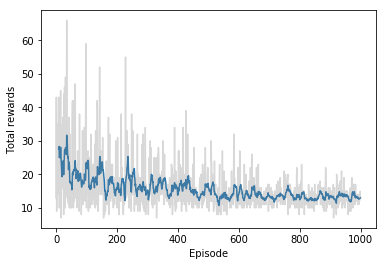

In [123]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average g_losses')

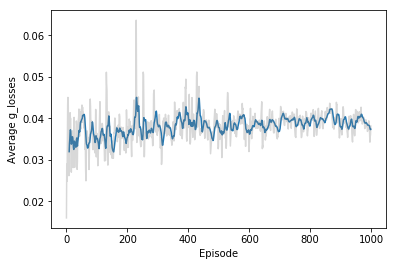

In [124]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average g_losses')

Text(0,0.5,'Average d_losses')

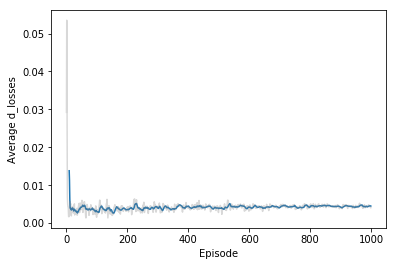

In [125]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average d_losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.